In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [52]:
Dataset_dir = ["./train.csv", "./store.csv","./test.csv"]
pd.options.display.max_columns = None

In [53]:
def load_data(dir):
    data = pd.read_csv(dir[0],parse_dates=[2])
    store = pd.read_csv(dir[1])
    test = pd.read_csv(dir[2],parse_dates=[3])
    return data,store,test

In [54]:
train,store,test = load_data(Dataset_dir)
train = train[train['Open'] != 0]
test = test[test['Open'] != 0]
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
print(train.columns)
print(test.columns)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [55]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.0,844392.000000,844392.000000,842206.000000,575773.000000,575773.000000,844392.000000,421085.000000,421085.000000
mean,558.422920,3.520361,6955.514291,762.728395,1.0,0.446352,0.193580,5457.979627,7.224879,2008.697747,0.498684,23.253426,2011.754019
std,321.731914,1.723689,3104.214680,401.227674,0.0,0.497114,0.395103,7809.437311,3.210144,5.978048,0.499999,14.100569,1.660962
min,1.000000,1.000000,0.000000,0.000000,1.0,0.000000,0.000000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,280.000000,2.000000,4859.000000,519.000000,1.0,0.000000,0.000000,710.000000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000,2320.000000,8.000000,2010.000000,0.000000,22.000000,2012.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.0,1.000000,0.000000,6890.000000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


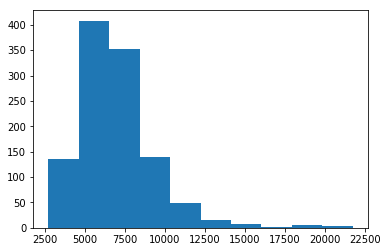

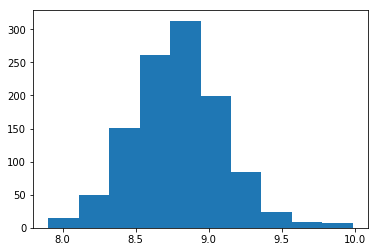

In [56]:
sales_mean = train.groupby('Store')['Sales'].mean()
plt.hist(sales_mean)
plt.show()
plt.hist(np.log1p(sales_mean))
plt.show()

In [57]:
Store_DaysWeek = train.groupby(['Store','DayOfWeek'])
sw_mean = Store_DaysWeek["Sales"].mean()

In [58]:
def build_feature(data,istrain):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    distance_max = max(data.CompetitionDistance)
    data.CompetitionDistance.mask(data.CompetitionDistance.isna(),other=distance_max,inplace=True)
    print(data.CompetitionDistance.isnull().any())
    min_max_scaler = MinMaxScaler()
    scaledata = min_max_scaler.fit_transform(data[['CompetitionDistance']])
    data.drop("CompetitionDistance",axis=1)
    data['CompetitionDistance'] = scaledata

#     scaledata = min_max_scaler.fit_transform(data[['Customers']])
#     data.drop("Customers",axis=1)
#     data['Customers'] = scaledata
    
    if istrain:
        data.drop(['Store','Open','Date','Customers','PromoInterval'],axis=1,inplace=True)
    else:
        data.drop(['Id','Store','Open','Date','PromoInterval'],axis=1,inplace=True)
    print(data.columns)

In [59]:
#build train data
build_feature(train,True)
#build test data
build_feature(test,False)

False
Index(['DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear'],
      dtype='object')
False
Index(['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear'],
      dtype='object')


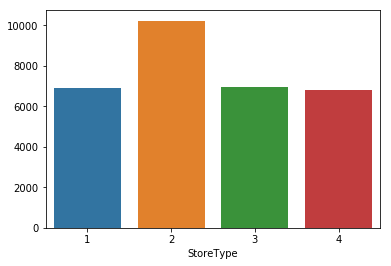

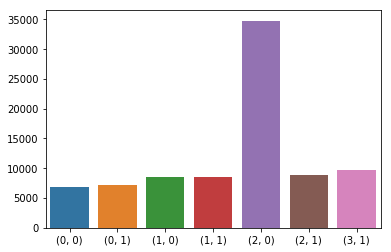

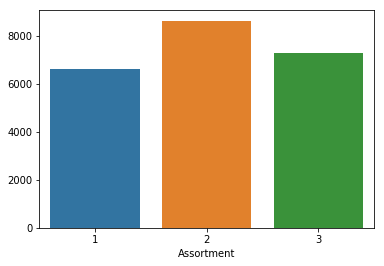

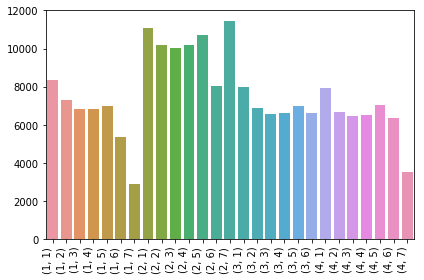

In [78]:
ST_gp = train.groupby('StoreType')['Sales'].agg('mean')
import seaborn as sns
sns.barplot(ST_gp.index,ST_gp.values)
plt.show()
StateOPen_gp = train.groupby(['StateHoliday','SchoolHoliday'])['Sales'].agg('mean')
sns.barplot(StateOPen_gp.index,StateOPen_gp.values)
plt.show()
As_gp = train.groupby('Assortment')['Sales'].agg('mean')
sns.barplot(As_gp.index,As_gp.values)
plt.show()
Dayweek_gp = train.groupby(['StoreType','DayOfWeek'])['Sales'].agg('mean')
ax = sns.barplot(Dayweek_gp.index,Dayweek_gp.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
print(train.size)
train.dropna(axis=0,how='any',inplace=True)
print(train.size)

11821488
3749368


In [11]:
#split train vaild data
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
Y_train = X_train["Sales"]
Y_valid = X_valid["Sales"]
X_train.drop("Sales",axis=1,inplace=True)
X_valid.drop("Sales",axis=1,inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


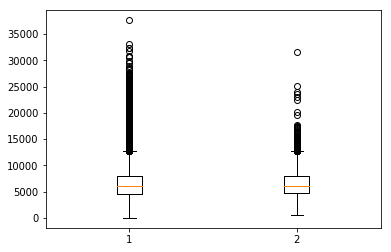

In [12]:
plt.boxplot([Y_train,Y_valid])
plt.show()

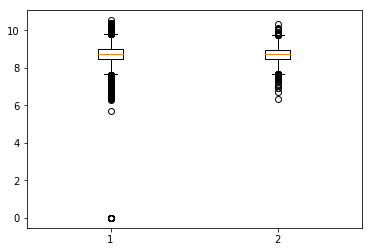

In [13]:
Y_train = np.log1p(Y_train)
Y_valid = np.log1p(Y_valid)
plt.boxplot([Y_train,Y_valid])
plt.show()

In [14]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

epohs = 20

In [15]:
params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 8,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300

dtrain = xgb.DMatrix(X_train, Y_train)
dvalid = xgb.DMatrix(X_valid, Y_valid)
#dtest = xgb.DMatrix(test)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=True)

# params = {'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 0.7,
#           'learning_rate': 0.3, 'loss': 'ls'}
# optimzer = GradientBoostingRegressor(**params)
# optimzer.fit(X_train,Y_train)


[0]	eval-rmse:5.76095	train-rmse:5.75449	eval-rmspe:0.99677	train-rmspe:0.996705
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:4.0405	train-rmse:4.03461	eval-rmspe:0.981325	train-rmspe:0.981181
[2]	eval-rmse:2.83725	train-rmse:2.83203	eval-rmspe:0.937936	train-rmspe:0.937571
[3]	eval-rmse:1.9973	train-rmse:1.9928	eval-rmspe:0.856882	train-rmspe:0.856067
[4]	eval-rmse:1.41086	train-rmse:1.4082	eval-rmspe:0.744271	train-rmspe:0.743009
[5]	eval-rmse:1.00529	train-rmse:1.00296	eval-rmspe:0.618863	train-rmspe:0.616293
[6]	eval-rmse:0.724481	train-rmse:0.723672	eval-rmspe:0.499634	train-rmspe:0.49543
[7]	eval-rmse:0.533282	train-rmse:0.534275	eval-rmspe:0.400562	train-rmspe:0.39355
[8]	eval-rmse:0.405039	train-rmse:0.408122	eval-rmspe:0.326962	train-rmspe:0.316489
[9]	eval-rmse:0.322921	train-rmse:0.32784	eval-rmspe:0.27936	train-rmspe:0.264811
[10]	eval-rmse:0.273241	train-rmse

[96]	eval-rmse:0.177174	train-rmse:0.183168	eval-rmspe:0.198279	train-rmspe:0.175662
[97]	eval-rmse:0.177201	train-rmse:0.183139	eval-rmspe:0.198287	train-rmspe:0.17559
[98]	eval-rmse:0.177124	train-rmse:0.183073	eval-rmspe:0.198228	train-rmspe:0.175483
[99]	eval-rmse:0.177134	train-rmse:0.183065	eval-rmspe:0.198154	train-rmspe:0.175441
[100]	eval-rmse:0.177093	train-rmse:0.183055	eval-rmspe:0.198075	train-rmspe:0.175414
[101]	eval-rmse:0.176978	train-rmse:0.182975	eval-rmspe:0.198109	train-rmspe:0.175342
[102]	eval-rmse:0.176964	train-rmse:0.182922	eval-rmspe:0.198136	train-rmspe:0.175102
[103]	eval-rmse:0.176928	train-rmse:0.182896	eval-rmspe:0.198145	train-rmspe:0.175115
[104]	eval-rmse:0.176976	train-rmse:0.182834	eval-rmspe:0.198134	train-rmspe:0.175064
[105]	eval-rmse:0.176967	train-rmse:0.182832	eval-rmspe:0.198181	train-rmspe:0.175068
[106]	eval-rmse:0.176933	train-rmse:0.182811	eval-rmspe:0.197628	train-rmspe:0.175108
[107]	eval-rmse:0.176899	train-rmse:0.182794	eval-rmspe:0.1

[192]	eval-rmse:0.175745	train-rmse:0.181511	eval-rmspe:0.195816	train-rmspe:0.173602
[193]	eval-rmse:0.175671	train-rmse:0.181505	eval-rmspe:0.195727	train-rmspe:0.173578
[194]	eval-rmse:0.175601	train-rmse:0.181497	eval-rmspe:0.195622	train-rmspe:0.173549
[195]	eval-rmse:0.175686	train-rmse:0.181492	eval-rmspe:0.195635	train-rmspe:0.17358
[196]	eval-rmse:0.175669	train-rmse:0.181475	eval-rmspe:0.195714	train-rmspe:0.173556
[197]	eval-rmse:0.175542	train-rmse:0.181468	eval-rmspe:0.195638	train-rmspe:0.173508
[198]	eval-rmse:0.17555	train-rmse:0.181467	eval-rmspe:0.195656	train-rmspe:0.173546
[199]	eval-rmse:0.175538	train-rmse:0.181456	eval-rmspe:0.195648	train-rmspe:0.17356
[200]	eval-rmse:0.175597	train-rmse:0.181449	eval-rmspe:0.196037	train-rmspe:0.173574
[201]	eval-rmse:0.175672	train-rmse:0.181438	eval-rmspe:0.196187	train-rmspe:0.173564
[202]	eval-rmse:0.175706	train-rmse:0.181433	eval-rmspe:0.196197	train-rmspe:0.173593
[203]	eval-rmse:0.175696	train-rmse:0.18143	eval-rmspe:0.

[288]	eval-rmse:0.175261	train-rmse:0.181027	eval-rmspe:0.194455	train-rmspe:0.172992
[289]	eval-rmse:0.175311	train-rmse:0.181028	eval-rmspe:0.19445	train-rmspe:0.173031
[290]	eval-rmse:0.175263	train-rmse:0.181026	eval-rmspe:0.194407	train-rmspe:0.173017
[291]	eval-rmse:0.17527	train-rmse:0.181026	eval-rmspe:0.194387	train-rmspe:0.173011
[292]	eval-rmse:0.175215	train-rmse:0.18102	eval-rmspe:0.19425	train-rmspe:0.172966
[293]	eval-rmse:0.175188	train-rmse:0.181019	eval-rmspe:0.194264	train-rmspe:0.172958
[294]	eval-rmse:0.175229	train-rmse:0.181019	eval-rmspe:0.194376	train-rmspe:0.173001
[295]	eval-rmse:0.175247	train-rmse:0.181019	eval-rmspe:0.194361	train-rmspe:0.173013
[296]	eval-rmse:0.17528	train-rmse:0.18102	eval-rmspe:0.194368	train-rmspe:0.173017
[297]	eval-rmse:0.175281	train-rmse:0.181015	eval-rmspe:0.1946	train-rmspe:0.172993
[298]	eval-rmse:0.175263	train-rmse:0.181014	eval-rmspe:0.194569	train-rmspe:0.173017
[299]	eval-rmse:0.175235	train-rmse:0.181014	eval-rmspe:0.1945

In [ ]:
train_mse = rmspe_xg(optimzer.predict(X_train),Y_train)
mse = rmspe_xg(optimzer.predict(X_valid),Y_valid)
print("train Mse is ",train_mse)
print("valild Mse is ",mse)